In [66]:
import random
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from make_dataset import get_data_for_days, calc_features

import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

In [ ]:
BASE_SEED = 42

deploy = True  # 本番用モデルを作成する場合はTrue

### Utils

In [68]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [69]:
seed_everything(BASE_SEED)

### Make dataset

In [70]:
training_end_date = "20241230"
# training_end_date = (datetime.now() - timedelta(days=1)).strftime("%Y%m%d")
training_days = 450

In [71]:
train_df = get_data_for_days(symbol="BTC_JPY", interval="1hour", end_date=training_end_date, days=training_days)

train_df.shape

(10704, 5)

In [72]:
train_df.tail()

,open,high,low,close,volume
openTime,,,,,
2024-12-31 01:00:00+09:00,14458444,14478278,14411249,14466928,37.44
2024-12-31 02:00:00+09:00,14468493,14799067,14452483,14729046,60.18
2024-12-31 03:00:00+09:00,14724000,14863728,14685553,14834378,46.68
2024-12-31 04:00:00+09:00,14833826,14846891,14737538,14816986,25.49
2024-12-31 05:00:00+09:00,14820215,14910000,14775814,14778297,29.54


In [73]:
# train_df.to_csv(os.path.join("data", "raw_data.csv"))
with open(os.path.join("data", "raw_data.pkl"), "wb") as f:
    pickle.dump(train_df, f)

In [74]:
# train_df = pd.read_pickle(os.path.join("data", "raw_data.pkl"))

In [75]:
train_df = calc_features(train_df, train=True)

train_df.shape

(10679, 21)

In [76]:
train_df.tail()

,return,high2low,high2mean,low2mean,high2median,low2median,return_mean_5,return_std_5,sharpe_5,return_mean_gap_5,return_mean_13,return_std_13,sharpe_13,return_mean_gap_13,return_mean_25,return_std_25,sharpe_25,return_mean_gap_25,target_return,target_return_sign,target_price_diff
openTime,,,,,,,,,,,,,,,,,,,,,
2024-12-31 00:00:00+09:00,0.002722,1.012343,1.005379,0.993121,1.004625,0.992376,-0.004378,0.006737,-0.649889,-3.301981e+09,-0.001845,0.004803,-0.384038,-7.837026e+09,-0.001362,0.004196,-0.324613,-1.061394e+10,0.000587,1,8484.0
2024-12-31 01:00:00+09:00,0.000587,1.004651,1.001699,0.997061,1.001078,0.996443,-0.004368,0.006746,-0.647511,-3.311842e+09,-0.001646,0.004850,-0.339444,-8.787713e+09,-0.001287,0.004214,-0.305444,-1.123928e+10,0.017848,1,260553.0
2024-12-31 02:00:00+09:00,0.017848,1.023981,1.012783,0.989065,1.013720,0.989980,-0.000373,0.012153,-0.030677,-3.950794e+10,0.000084,0.007155,0.011734,1.754351e+11,-0.000308,0.005552,-0.055492,-4.780444e+10,0.007469,1,110378.0
2024-12-31 03:00:00+09:00,0.007469,1.012133,1.005875,0.993817,1.005720,0.993664,0.003486,0.010567,0.329877,4.255558e+09,0.000472,0.007424,0.063572,3.142959e+10,-0.000018,0.005766,-0.003038,-8.469315e+11,-0.001136,0,-16840.0
2024-12-31 04:00:00+09:00,-0.001136,1.007420,1.002571,0.995187,1.001449,0.994073,0.005498,0.007620,0.721515,2.695077e+09,0.000137,0.007388,0.018576,1.079594e+11,0.000053,0.005740,0.009226,2.797841e+11,-0.002832,0,-41918.0


In [77]:
# train_df.to_csv(os.path.join("data", "feature_data.csv"))
with open(os.path.join("data", "feature_data.pkl"), "wb") as f:
    pickle.dump(train_df, f)

### Train

In [78]:
target = "target_return_sign"
# feature_cols = [f for f in train_df.columns if f not in ["target_return", "target_return_sign", "target_price_diff"]]
feature_cols = [
    "return",
    "return_std_5",
    "sharpe_5",
    ]

test_ratio = 0.2
purge_size = 25

lgb_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "max_depth": 11,
    # "num_leaves": 256,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 1.0,
    # "extra_trees": True,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "seed": BASE_SEED
}

In [82]:
def train_test_split(df, test_ratio=0.2, purge_size=0):
    total_size = len(df)
    test_size = int(total_size * test_ratio)
    train_size = total_size - test_size - purge_size

    return df.iloc[:train_size], df.iloc[train_size + purge_size:]


def cross_validation_modeling(df, target, feature_cols, lgb_params, n_splits=5, purge_size=0, deploy=False):
    print("#### Train ####")

    n = len(df)
    idx = np.arange(n)

    valid_scores = []
    models = []

    for i in range(n_splits):
        print("## Fold: {} ##".format(i))

        valid_start = i * n // n_splits
        valid_end = (i + 1) * n // n_splits
        valid_idx = idx[valid_start:valid_end]
        train_idx = idx[(idx < valid_start - purge_size) | (valid_end + purge_size <= idx)]
        train, valid = df.iloc[train_idx], df.iloc[valid_idx]

        print("train length: {}".format(len(train)))
        print("valid length: {}".format(len(valid)))

        train_X, valid_X = train[feature_cols], valid[feature_cols]
        train_y, valid_y = train[target], valid[target]

        # modeling
        model = lgb.LGBMClassifier(**lgb_params)

        model.fit(
                    train_X,
                    train_y,
                    eval_set=[(valid_X, valid_y)],
                    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
                )

        valid_scores.append(model.best_score_["valid_0"]["binary_logloss"])
        models.append(model)
        if deploy:
            with open(os.path.join("models", f"model_{i}.pkl"), "wb") as f:
                pickle.dump(model, f)

        # # feature importance
        # feature_importance = pd.DataFrame(model.booster_.feature_importance(importance_type="gain"), index=trn_X.columns, columns=["importance"])
        # feature_importance = feature_importance.sort_values("importance", ascending=False)
        # display(feature_importance)

        # permutation importance
        perm_importance = permutation_importance(model, train_X, train_y, scoring="neg_log_loss", n_repeats=10, random_state=BASE_SEED, n_jobs=-1)

        perm_importance = pd.DataFrame({
            "feature": train_X.columns.to_list(),
            "importance_mean": perm_importance.importances_mean,
            "importance_std": perm_importance.importances_std
        }).sort_values(by="importance_mean", ascending=False)

        # display(perm_importance)

        plt.figure(figsize=(10, 6))
        plt.barh(perm_importance["feature"], perm_importance["importance_mean"], xerr=perm_importance["importance_std"])
        plt.xlabel("Permutation Importance")
        plt.ylabel("Feature")
        plt.title("Permutation Importance of Features")
        plt.gca().invert_yaxis()
        plt.show()

    print("## Result ##")
    print("scores: {}".format([float(f"{x:.4f}") for x in valid_scores]))
    print("mean: {:.4f}".format(np.mean(valid_scores)))
    print("std: {:.4f}".format(np.std(valid_scores)))

    return models


# richman non-stationarity score
def non_stationarity_score(df, feature_cols):
    print("## Non-Stationarity Check ##")

    model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
    model.fit(df[feature_cols], np.arange(df.shape[0]))
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, feature_cols)), columns=["Value","Feature"])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title("LightGBM Features adv val (avg over folds)")
    plt.tight_layout()
    plt.show()

    cv = KFold(n_splits=2, shuffle=True, random_state=0)
    scores = cross_val_score(model, df[feature_cols], np.arange(df.shape[0]), scoring="r2", cv=cv)
    print("scores", scores)
    print("score mean, std", np.mean(scores), np.std(scores))


def evaluate(models, test, feature_cols):
    print("#### Evalute ####")

    result_df = test.copy()
    result_df["pred_proba"] = 0
    for model in models:
        result_df["pred_proba"] += model.predict_proba(test[feature_cols])[:, 1]

    result_df["pred_proba"] /= len(models)
    result_df["pred"] = result_df["pred_proba"].apply(lambda x: 1 if x >= 0.5 else 0)
    result_df["exe_decision"] = result_df["pred_proba"].apply(lambda x: 1 if x >= 0.5 else -1)
    # result_df["profit"] = result_df["exe_decision"] * result_df["target_return"]
    result_df["target_price_diff"] = result_df["target_price_diff"] * 0.01  # 注文サイズに合わせる
    result_df["profit"] = result_df["exe_decision"] * result_df["target_price_diff"]

    print("Profit during test period: ", int(result_df["profit"].sum()))
    print("Benchmark: ", int(result_df["target_price_diff"].sum()))

    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df["profit"].cumsum(), label="Model Strategy")
    plt.plot(result_df.index, result_df["target_price_diff"].cumsum(), label="Benchmark")
    plt.legend()
    plt.title("Cumulative Profit")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df["profit"], label="Model Strategy")
    plt.legend()
    plt.title("Profit")
    plt.show()

    print("Accuracy: ", round(accuracy_score(result_df["target_return_sign"], result_df["pred"]), 4))
    print("Benchmark: ", round(result_df["target_return_sign"].mean(), 4))

    # 混同行列
    conf_matrix = confusion_matrix(result_df["target_return_sign"], result_df["pred"])

    fig, ax = plt.subplots(figsize=(8, 5))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f"{val}", ha="center", va="center")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    plt.show()

    return result_df

#### Train ####
## Fold: 0 ##
train length: 6791
valid length: 1703
[LightGBM] [Info] Number of positive: 3478, number of negative: 3313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6791, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512148 -> initscore=0.048603
[LightGBM] [Info] Start training from score 0.048603
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.688354
[100]	valid_0's binary_logloss: 0.686722
[150]	valid_0's binary_logloss: 0.686726
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.686668


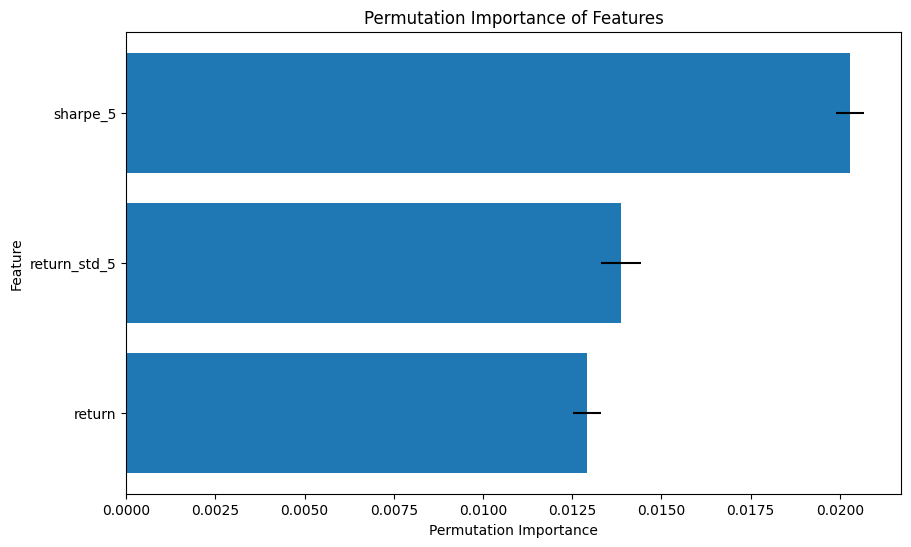

## Fold: 1 ##
train length: 6765
valid length: 1704
[LightGBM] [Info] Number of positive: 3469, number of negative: 3296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6765, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512786 -> initscore=0.051157
[LightGBM] [Info] Start training from score 0.051157
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.690138
[100]	valid_0's binary_logloss: 0.690067
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.689777


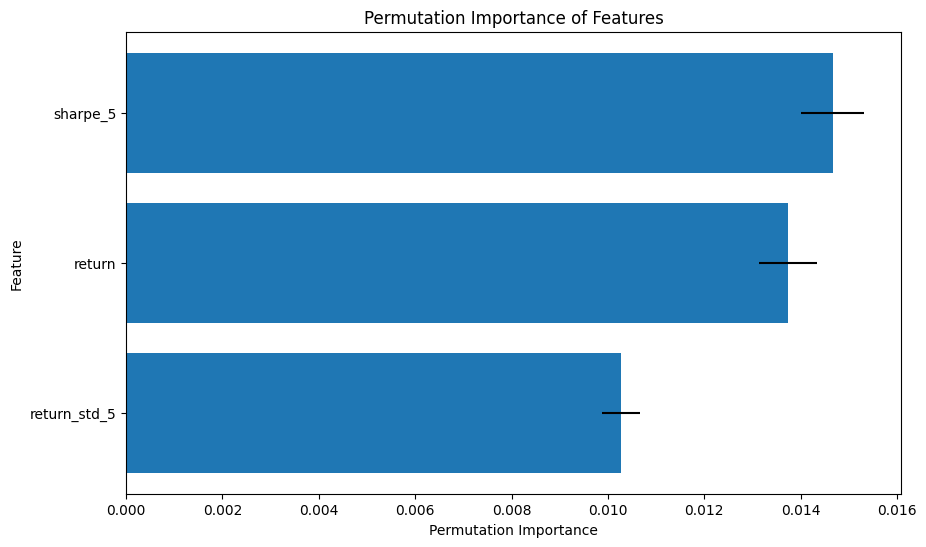

## Fold: 2 ##
train length: 6765
valid length: 1704
[LightGBM] [Info] Number of positive: 3452, number of negative: 3313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6765, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510273 -> initscore=0.041100
[LightGBM] [Info] Start training from score 0.041100
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.689229
[100]	valid_0's binary_logloss: 0.68877
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.688732


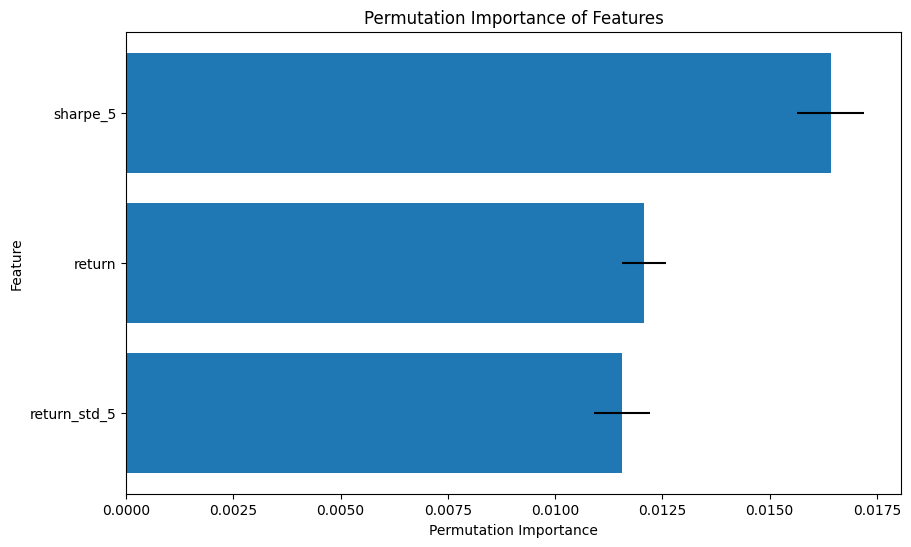

## Fold: 3 ##
train length: 6765
valid length: 1704
[LightGBM] [Info] Number of positive: 3461, number of negative: 3304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6765, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511604 -> initscore=0.046424
[LightGBM] [Info] Start training from score 0.046424
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.689478
[100]	valid_0's binary_logloss: 0.688917
[150]	valid_0's binary_logloss: 0.689223
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.688791


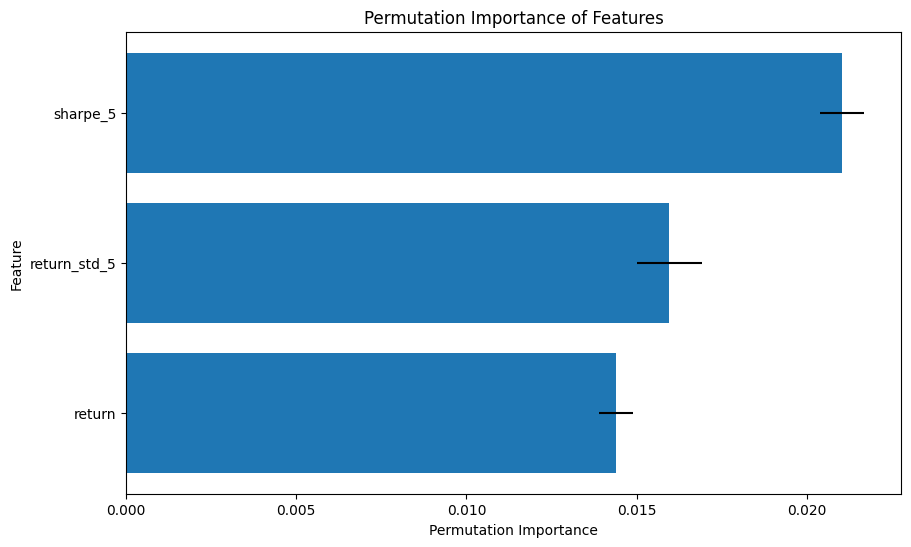

## Fold: 4 ##
train length: 6790
valid length: 1704
[LightGBM] [Info] Number of positive: 3476, number of negative: 3314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6790, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511929 -> initscore=0.047726
[LightGBM] [Info] Start training from score 0.047726
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.690878
[100]	valid_0's binary_logloss: 0.691051
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.690652


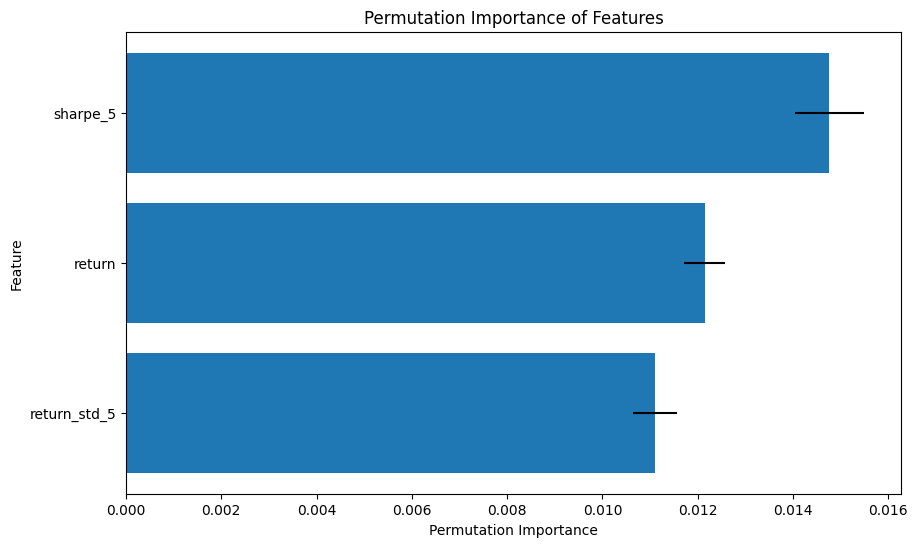

## Result ##
scores: [0.6867, 0.6898, 0.6887, 0.6888, 0.6907]
mean: 0.6889
std: 0.0013
## Non-Stationarity Check ##
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8519, number of used features: 3
[LightGBM] [Info] Start training from score 4259.000000


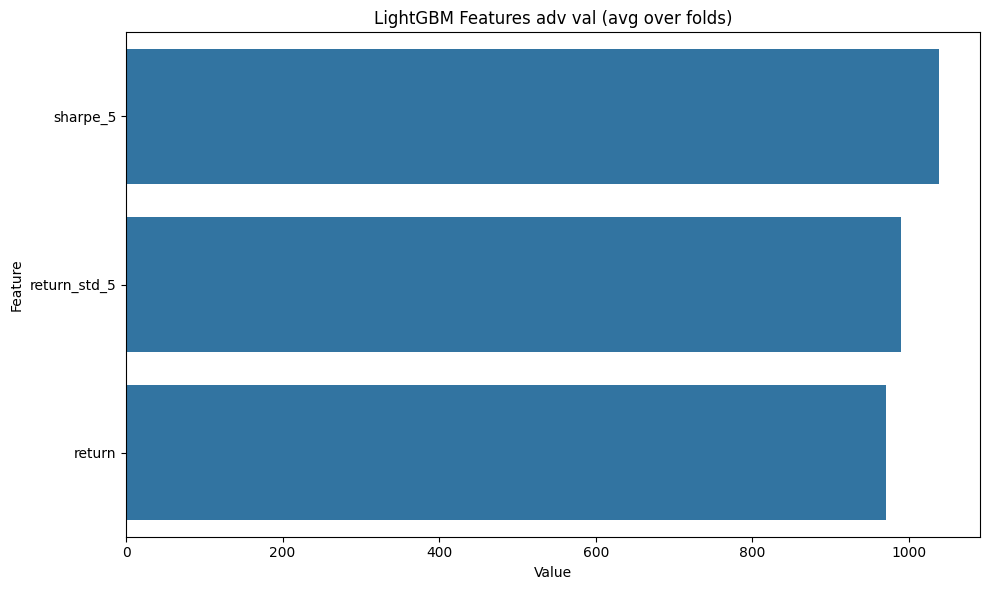

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4259, number of used features: 3
[LightGBM] [Info] Start training from score 4267.700869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4260, number of used features: 3
[LightGBM] [Info] Start training from score 4250.301174
scores [-0.02878058 -0.03101528]
score mean, std -0.029897929726365624 0.001117349334667339
#### Evalute ####
Profit during test period:  127197
Benchmark:  56654


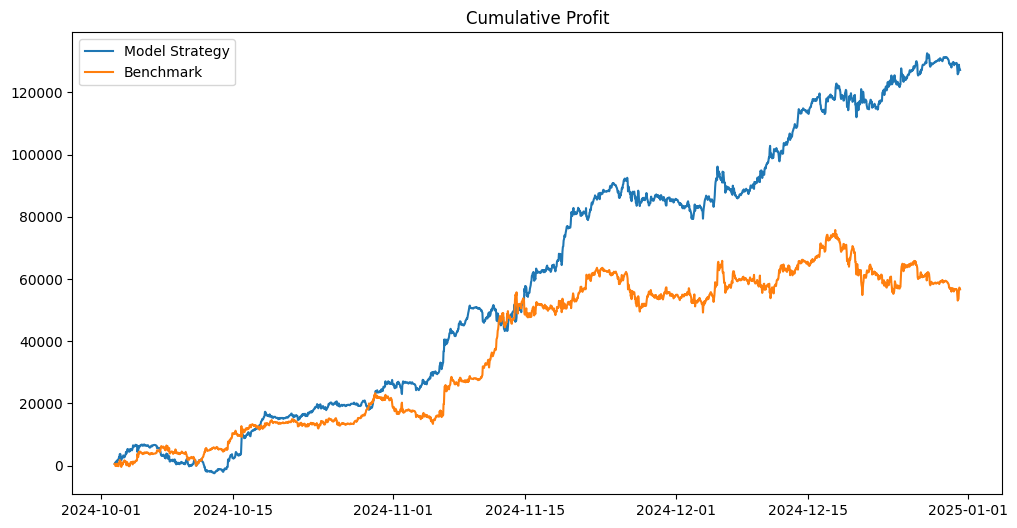

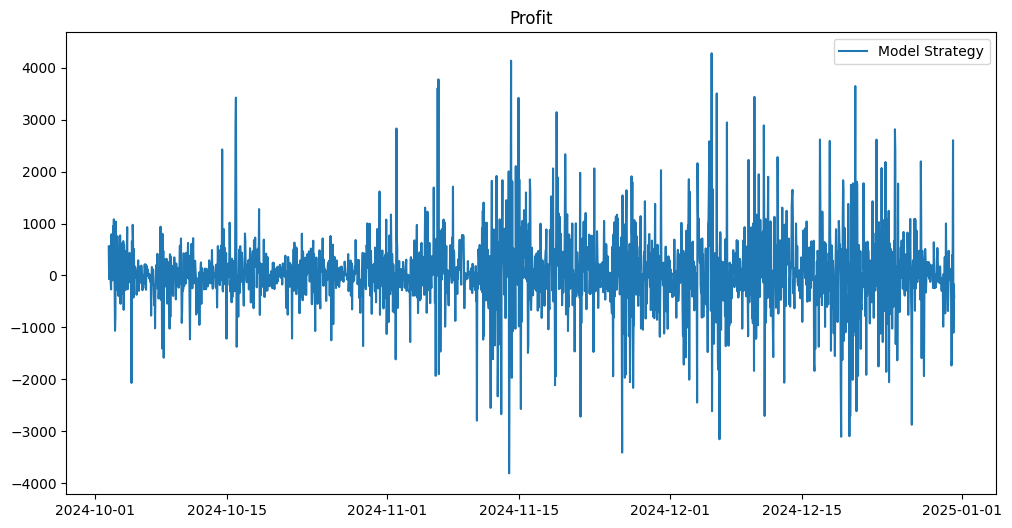

Accuracy:  0.5555
Benchmark:  0.5302


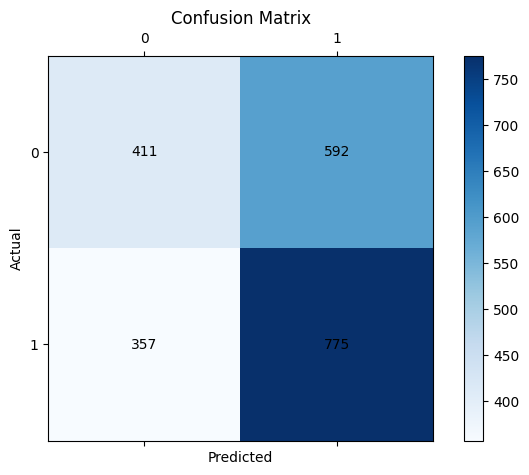

In [83]:
if deploy:
    models = cross_validation_modeling(train_df, target, feature_cols, lgb_params, n_splits=5, purge_size=purge_size, deploy=deploy)
    non_stationarity_score(train_df, feature_cols)
else:
    train, test = train_test_split(train_df, test_ratio=test_ratio, purge_size=purge_size)
    models = cross_validation_modeling(train, target, feature_cols, lgb_params, n_splits=5, purge_size=purge_size, deploy=deploy)
    non_stationarity_score(train, feature_cols)
    result_df = evaluate(models, test, feature_cols)